In [1]:
import keras
import os
import librosa


import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

from keras.models import Sequential
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\lenovo_pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\Dataset-merged'
feature_dim_1 = 7

In [3]:
def get_labels(path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))    
    return labels, label_indices, to_categorical(label_indices)





In [4]:


def save_data_to_array(path, max_pad_len):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        melspectrogram_vectors = []

        wavfiles = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        #wavfiles = librosa.util.find_files(db)
        #print(wavfiles)
        x=0
        for wavfile in wavfiles:
            name=label+'_'+str(x)
            melspectrogram = wav2melspectrogram(wavfile, name, max_pad_len=max_pad_len)            
            melspectrogram_vectors.append(melspectrogram)            
            x=x+1
        
        #computing PCA and saving
        
        np.save(label + '.npy', melspectrogram_vectors)
        #y=np.load(label + '.npy')
        #y = sklearn.preprocessing.scale(y)
        #y.mean()
        #model = sklearn.decomposition.PCA(n_components=2, whiten=True)
        #model.fit(y)
        #y = model.transform(y)
        #pd.DataFrame(y).to_csv(VALUE_PATH+'/'+label+'.csv')
        
        
sample_x=[]

def wav2melspectrogram(file_path, name, max_pad_len):
    wave, sr = librosa.load(file_path)
    x = librosa.feature.melspectrogram(wave, sr=sr)
    pad_width = max_pad_len - x.shape[1]
    x = np.pad(x, pad_width=((0, 0), (0, pad_width)), mode='constant')
    #here the dimensions are getting reduced 
    #through PCA decompostion
    x = reduce_dimension(x)
    #pd.DataFrame(x).to_csv(VALUE_PATH+'/'+name+'.csv')
    return x.T

In [5]:
NCOMPONENTS = feature_dim_1
def reduce_dimension(X):
    scaler = StandardScaler()
    scaler.fit(X.T)
    X_data = scaler.transform(X.T)
    
    kpca = KernelPCA(n_components=NCOMPONENTS)
    X_kpca = kpca.fit_transform(X.T)
    
    return X_kpca.T

In [6]:
from sklearn.model_selection import train_test_split


def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    # print(X.shape[0]) returns: 129
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        #print(X.shape[0]) returns: 129+152=281
        #print(i) returns: 0: So all y values are 1 for Seven and 0 for Tin
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



In [7]:


#db = r'C:\Users\lenovo_pc\Desktop\CNN_SR\SampleData'


# Second dimension of the feature is dim2
feature_dim_2 = 28

# Save data to array file first
save_data_to_array(DATA_PATH,feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
channel = 1
epochs = 50
batch_size = 100
verbose = 1
num_classes = 2


y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

C:\Users\lenovo_pc\Anaconda3\lib\site-packages\sklearn\decomposition\kernel_pca.py:264: RuntimeWarning: invalid value encountered in sqrt
  X_transformed = self.alphas_ * np.sqrt(self.lambdas_)


In [8]:

#X_train = np.array(x_train)
print(X_train.shape)
print(X_test.shape)

(472, 28, 7)
(119, 28, 7)


# *********++++++*********++++++*********++++++*********++++++

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras import regularizers
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

In [10]:
#seq_length = NCOMPONENTS

#model = Sequential()
#model.add(Conv1D(64, 3, activation='relu', input_shape=(feature_dim_2,seq_length), padding='causal'))
#model.add(Conv1D(64, 3, activation='relu'))
#model.add(MaxPooling1D(3))
#model.add(Conv1D(128, 3, activation='relu'))
#model.add(Conv1D(128, 3, activation='relu'))
#model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.5))
#model.add(Dense(2, activation='sigmoid'))

In [11]:


model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(feature_dim_2,feature_dim_1) ,padding='causal'))
model.add(Conv1D(64, 3, activation='relu', ))
model.add(MaxPooling1D(3))
#model.add(Conv1D(128, 3, activation='relu', ))
#model.add(Conv1D(128, 3, activation='relu', ))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.7))
model.add(Dense(2, activation='sigmoid'))


In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [13]:
#model.fit(x_train, y_train, batch_size=7, epochs=10)

history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=50, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 472 samples, validate on 119 samples
Epoch 1/50
472/472 [==============================] - 10s 21ms/step - loss: nan - acc: 0.3252 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/50
472/472 [==============================] - 9s 20ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 3/50
472/472 [==============================] - 9s 19ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 4/50
472/472 [==============================] - 10s 21ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 5/50
472/472 [==============================] - 10s 22ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 6/50
472/472 [==============================] - 9s 18ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 7/50
472/472 [==============================] - 10s 22ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 8/5

In [14]:
score = model.evaluate(X_train, y_train_hot, verbose=0) 
print ("model train data score: acc       : ",round(score[1]*100,2) , "%")
print ("model train data score: loss      : ",round(score[0]*100,2) , "%")

score = model.evaluate(X_test, y_test_hot, verbose=0) 
print ("model test data score: acc        : ",round(score[1]*100,2) , "%")
print ("model test data score: loss       : ",round(score[0]*100,2) , "%")


model train data score: acc       :  0.0 %
model train data score: loss      :  nan %
model test data score: acc        :  0.0 %
model test data score: loss       :  nan %


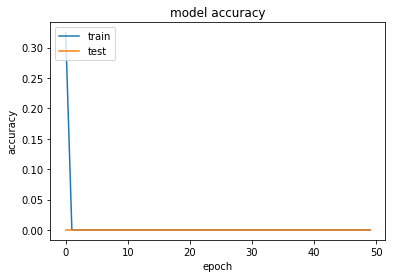

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

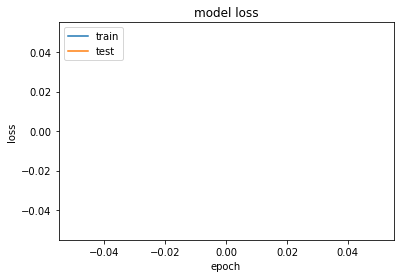

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# RNN+LSTM


In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [18]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.1, recurrent_dropout=0.15, kernel_regularizer=l2(0.05), recurrent_regularizer=l2(0.08), bias_regularizer=l2(0.06), return_sequences=True))
model.add(LSTM(units=32, dropout=0.6, recurrent_dropout=0.60, kernel_regularizer=l2(0.90), recurrent_regularizer=l2(0.90), bias_regularizer=l2(0.10), return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
#model.summary()

Build LSTM RNN model ...


In [19]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=50
MAX_BATCH=7

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(X_train, y_train_hot, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(X_test, y_test_hot),
                  callbacks=callback) 
model.summary()
print ("training finised!")


training started..... please wait.


C:\Users\lenovo_pc\Anaconda3\lib\site-packages\keras\callbacks.py:1090: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
C:\Users\lenovo_pc\Anaconda3\lib\site-packages\keras\callbacks.py:436: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):



Epoch 00001: loss did not improve from inf

Epoch 00002: loss did not improve from inf

Epoch 00003: loss did not improve from inf

Epoch 00004: loss did not improve from inf

Epoch 00005: loss did not improve from inf

Epoch 00006: loss did not improve from inf

Epoch 00007: loss did not improve from inf

Epoch 00008: loss did not improve from inf

Epoch 00009: loss did not improve from inf

Epoch 00010: loss did not improve from inf

Epoch 00011: loss did not improve from inf

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00012: loss did not improve from inf

Epoch 00013: loss did not improve from inf

Epoch 00014: loss did not improve from inf

Epoch 00015: loss did not improve from inf

Epoch 00016: loss did not improve from inf

Epoch 00017: loss did not improve from inf

Epoch 00018: loss did not improve from inf

Epoch 00019: loss did not improve from inf

Epoch 00020: loss did not improve from inf

Epoch 00021: loss did not improve fro

In [20]:
score = model.evaluate(X_train, y_train_hot, verbose=0) 
print ("model train data score       : ",round(score[1]*100,2) , "%")
print ("model train data loss        : ",round(score[0],2) , "%")

score = model.evaluate(X_test, y_test_hot, verbose=0) 
print ("model test data score        : ",round(score[1]*100,2) , "%")
print ("model train data loss        : ",round(score[0],2) , "%")

model train data score       :  47.25 %
model train data loss        :  nan %
model test data score        :  51.26 %
model train data loss        :  nan %


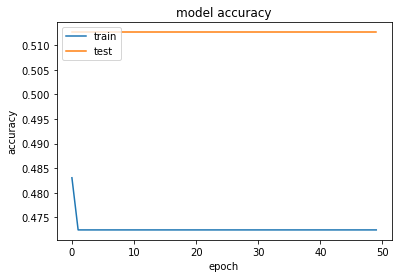

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

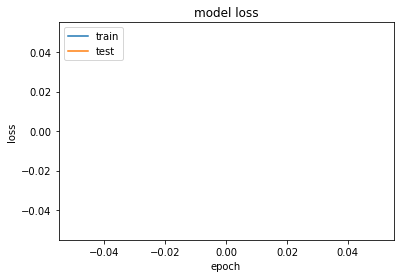

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()